In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('../data/ex_train.csv')
val_df = pd.read_csv('../data/ex_val.csv')
test_df = pd.read_csv('../data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Single-step model 

In [11]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [13]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0432 - val_loss: 0.0020 - val_mean_absolute_error: 0.0301
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0277 - val_loss: 0.0018 - val_mean_absolute_error: 0.0274
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0256 - val_loss: 0.0018 - val_mean_absolute_error: 0.0267
Epoch 4/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0250 - val_loss: 0.0018 - val_mean_absolute_error: 0.0267
Epoch 5/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0018 - val_mean_absolute_error: 0.0266
Epoch 6/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0246 - val_loss: 0.0018 - val_mean_absolute_error: 0.0269
Epoch 7/50
413/4

In [14]:
# Values obtained from chapter 14

mae_val = [0.029, 0.028, 0.029]
mae_test = [0.033, 0.032, 0.034]

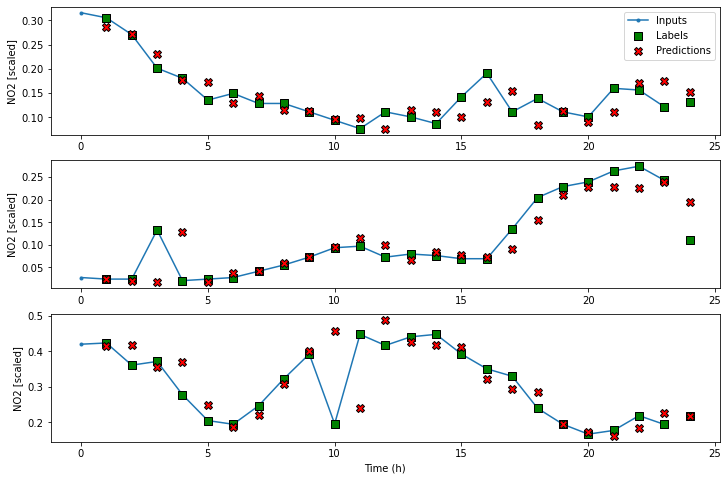

In [15]:
wide_window.plot(lstm_model)

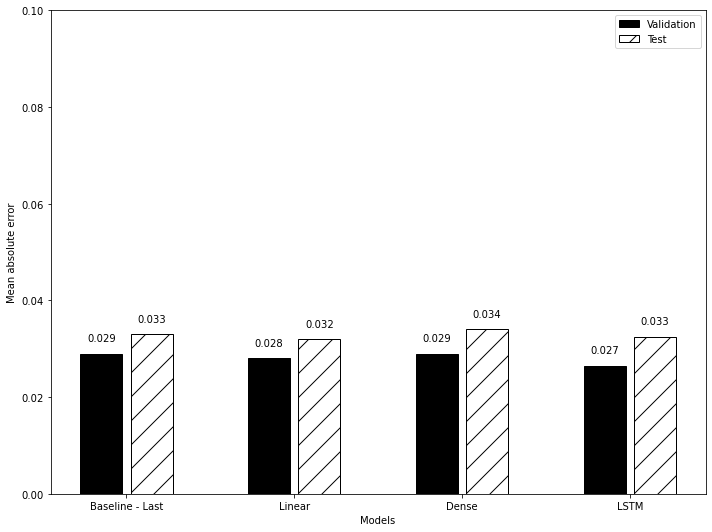

In [16]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model 

In [17]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [18]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0905 - val_loss: 0.0089 - val_mean_absolute_error: 0.0704
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0818 - val_loss: 0.0089 - val_mean_absolute_error: 0.0701
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0110 - mean_absolute_error: 0.0795 - val_loss: 0.0095 - val_mean_absolute_error: 0.0718
Epoch 4/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0107 - mean_absolute_error: 0.0785 - val_loss: 0.0087 - val_mean_absolute_error: 0.0690
Epoch 5/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0106 - mean_absolute_error: 0.0779 - val_loss: 0.0086 - val_mean_absolute_error: 0.0683
Epoch 6/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0104 - mean_absolute_error: 0.0773 - val_loss: 0.0086 - val_mean_absolute_error: 0.0688
Epoch 7/50
413/4

In [19]:
# Values obtained from chapter 14

ms_mae_val = [0.282, 0.282, 0.070, 0.071]
ms_mae_test = [0.243, 0.244, 0.115, 0.114]

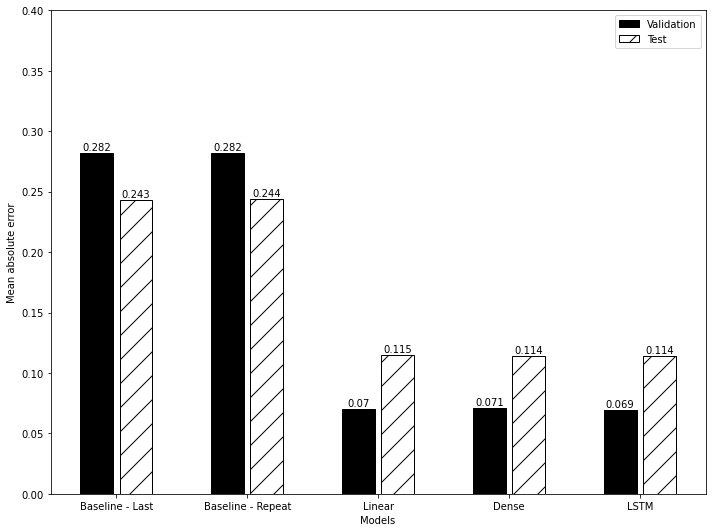

In [20]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model 

In [21]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])

In [22]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [24]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0167 - mean_absolute_error: 0.0783 - val_loss: 0.0046 - val_mean_absolute_error: 0.0442
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0395 - val_loss: 0.0023 - val_mean_absolute_error: 0.0323
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0302 - val_loss: 0.0016 - val_mean_absolute_error: 0.0272
Epoch 4/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0255 - val_loss: 0.0013 - val_mean_absolute_error: 0.0236
Epoch 5/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0228 - val_loss: 0.0012 - val_mean_absolute_error: 0.0217
Epoch 6/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0213 - val_loss: 0.0011 - val_mean_absolute_error: 0.0208
Epoch 7/50
413/4

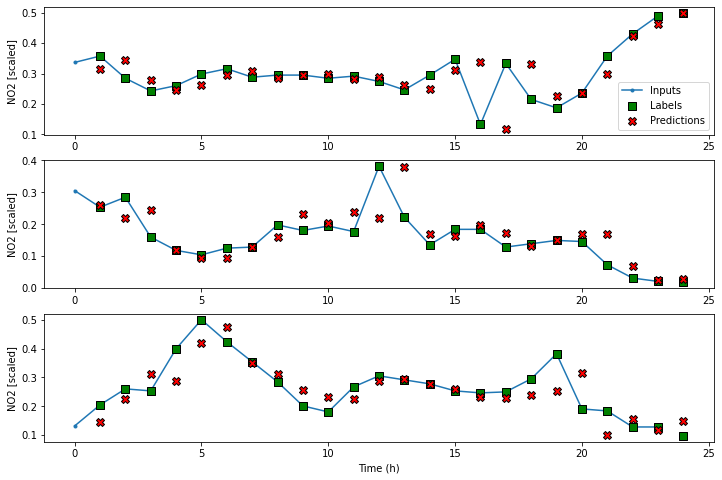

In [25]:
mo_wide_window.plot(mo_lstm_model)

In [26]:
# Values from chapter 14

mo_mae_val = [0.021, 0.020, 0.020]
mo_mae_test = [0.025, 0.023, 0.025]

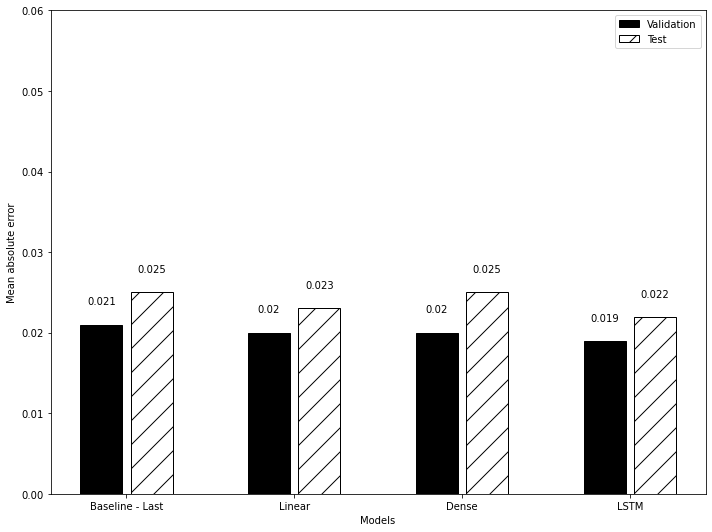

In [27]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()